In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
# Function to calculate train resistance at a given velocity (normal + additional resistances)
def train_resistance(v, A, B, C, curve_resistance=0, gradient_resistance=0):
    return A + B * v + C * v**2 + curve_resistance + gradient_resistance

In [3]:
# Function to calculate coasting deceleration at a given speed
def coasting_deceleration(v, A, B, C, mass_train, curve_resistance=0, gradient_resistance=0):
    F_r = train_resistance(v, A, B, C, curve_resistance, gradient_resistance)
    return -F_r / mass_train  # Deceleration is negative since it opposes motion

In [4]:
# Function to calculate average speed with re-acceleration phase for a segment
def calculate_average_speed_with_reacceleration(d, accelerate, retard, maxm_speed, A, B, C, mass_train, curve_resistance=0, gradient_resistance=0):
    # Time to accelerate and brake
    t_accel = maxm_speed / accelerate
    t_brake = maxm_speed / retard

    # Distance covered during acceleration and braking phases
    d_accel = 0.5 * accelerate * t_accel**2
    d_brake = 0.5 * retard * t_brake**2

    # Check if the train reaches max speed
    if d_accel + d_brake > d:
        # The train never reaches max speed
        t_total = np.sqrt(2 * d / (accelerate + retard))
        avg_speed = d / t_total
        return avg_speed, t_total, t_total / 2, 0, t_total / 2, 0  # t_coast = 0, reacceleration = 0
    else:
        # Distance to cover during coasting
        d_coast = d - (d_accel + d_brake)
        v = maxm_speed  # starting speed for coasting
        dt = 0.1  # time step
        t_coast = 0

        # Threshold for speed to trigger re-acceleration
        speed_threshold = 0.9 * maxm_speed
        reacceleration_times = 0

        while v > 0 and d_coast > 0:
            decel = coasting_deceleration(v, A, B, C, mass_train, curve_resistance, gradient_resistance)
            v = max(0, v + decel * dt)  # Update velocity based on deceleration
            d_coast -= v * dt  # Update distance covered during this time step
            t_coast += dt

            # Check if speed falls below 90% of max speed and trigger re-acceleration
            if v < speed_threshold and d_coast > 0:
                while v < maxm_speed and d_coast > 0:
                    v += accelerate * dt  # Accelerate back to max speed
                    d_coast -= v * dt
                    t_coast += dt
                reacceleration_times += 1

        # Total time
        t_total = t_accel + t_coast + t_brake
        avg_speed = d / t_total
        return avg_speed, t_total, t_accel, t_coast, t_brake, reacceleration_times


In [5]:
# Function to plot speed vs time for multiple stations
def plot_speed_vs_time_with_reacceleration(distances, accelerate, retard, maxm_speed, A, B, C, mass_train, curve_resistances, gradient_resistances):
    total_time = 0
    time_points = []
    speed_points = []

    for idx, d in enumerate(distances):
        curve_res = curve_resistances[idx] if idx < len(curve_resistances) else 0
        gradient_res = gradient_resistances[idx] if idx < len(gradient_resistances) else 0
        
        avg_speed, segment_time, t_accel, t_coast, t_brake, reaccel_times = calculate_average_speed_with_reacceleration(
            d, accelerate, retard, maxm_speed, A, B, C, mass_train, curve_res, gradient_res
        )
        time_points_segment = np.linspace(total_time, total_time + segment_time, 500)
        speed_points_segment = np.zeros_like(time_points_segment)

        for i in range(len(time_points_segment)):
            t = time_points_segment[i] - total_time
            if t < t_accel:
                speed_points_segment[i] = accelerate * t
            elif t < t_accel + t_coast:
                v_prev = speed_points_segment[i-1] if i > 0 else m
                decel = coasting_deceleration(v_prev, A, B, C, mass_train, curve_res, gradient_res)
                speed_points_segment[i] = max(0, v_prev + decel * (time_points_segment[i] - time_points_segment[i-1]))
                if speed_points_segment[i] < 0.9 * maxm_speed:
                    # Re-accelerate when speed drops below 90% of max speed
                    speed_points_segment[i] += accelerate * (time_points_segment[i] - time_points_segment[i-1])
            else:
                time_since_brake = t - t_accel - t_coast
                speed_points_segment[i] = max(0, maxm_speed - retard * time_since_brake)

        # Append time and speed points
        time_points.extend(time_points_segment)
        speed_points.extend(speed_points_segment)
        total_time += segment_time

    # Plot the graph
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, speed_points, label='Speed vs Time with Re-Acceleration')
    plt.fill_between(time_points, 0, speed_points, alpha=0.3)
    plt.title("Speed vs Time Graph with Re-Acceleration (Multiple Stations)")
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (m/s)")
    plt.grid(True)
    plt.legend()
    plt.show()


In [6]:
# Read station details from CSV file
stations_data = pd.read_csv('stn.csv')

# Calculate inter-station distances from chainages
distances = stations_data['Chainage in km'].diff().fillna(0).tolist()[1:]  # Skip the first station (no previous station to calculate distance)
print(distances)

[2200.0, 1900.0, 3100.0, 1800.0, 2700.0]


In [7]:
# Hardcoded values for station distances (in meters)
#distances = [2200, 1900, 3400]  # Distances between stations A->B, B->C, and C->D

# Hardcoded values for friction coefficients and train parameters
#A = 100  # constant friction coefficient
#B = 10  # linear friction coefficient
#C = 10  # quadratic friction coefficient
#accelerate = 1.0  # acceleration (m/s²)
#retard = 1.0  # braking rate (m/s²)
#maxm_speed = 20  # maximum speed (m/s)
#mass_train = 100000  # mass of the train (kg)

In [8]:
# Input for friction coefficients (A, B, C)
A = float(input("Enter the constant friction coefficient A: "))
B = float(input("Enter the linear friction coefficient B: "))
C = float(input("Enter the quadratic friction coefficient C: "))

# Input for train parameters (acceleration, braking, max speed, and mass)
accelerate = float(input("Enter the acceleration (m/s²): "))
retard = float(input("Enter the braking rate (m/s²): "))
maxm_speed = float(input("Enter the maximum speed (Km/hr): "))
mass_train = float(input("Enter the mass of the train (Ton): "))

# Convert maxm_speed to m/s² and mass to kg
maxm_speed =  maxm_speed * 1000/3600
mass_train = mass_train * 1000

Enter the constant friction coefficient A:  10
Enter the linear friction coefficient B:  10
Enter the quadratic friction coefficient C:  10
Enter the acceleration (m/s²):  1
Enter the braking rate (m/s²):  1
Enter the maximum speed (Km/hr):  80
Enter the mass of the train (Ton):  200


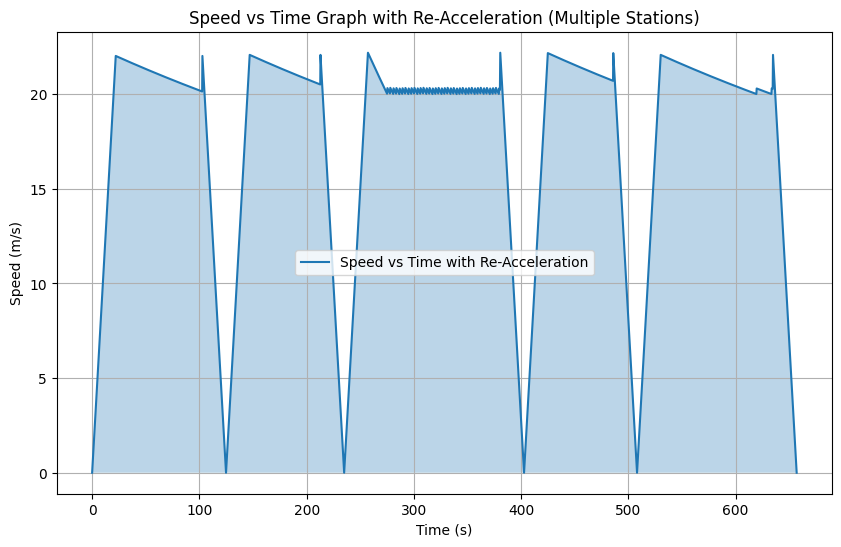

In [9]:
# Curve and gradient resistances for each segment
curve_resistances = [600 / 200, 0, 0]  # Example: 1 in 200 curve between A -> B
gradient_resistances = [0, 0, 9.81 * 1 / 100 * mass_train]  # Example: 1 in 100 gradient between C -> D

# Plot speed vs time for multiple stations with re-acceleration logic
plot_speed_vs_time_with_reacceleration(distances, accelerate, retard, maxm_speed, A, B, C, mass_train, curve_resistances, gradient_resistances)

The average speed of a metro train can be calculated by analyzing the phases of the journey: acceleration, cruising at max speed, and braking.

To derive the average speed, we can use the following logic:

1. **Acceleration Phase**: The train accelerates from 0 to maximum speed.
2. **Cruising Phase**: The train maintains the maximum speed until it begins braking.
3. **Coasting Phase**: The train's speed gradually decreases due to the deceleration caused by friction, which depends on the current speed.
4. **Braking Phase**: The train decelerates to 0 at the destination.

The total distance covered during acceleration and braking can be split up.

$t_a = \frac{m}{a}$, 

$t_b = \frac{m}{b}$


To account for friction during the cruising (now coasting) phase, we can incorporate the train resistance equation. The coasting phase will involve the train gradually decelerating due to the resistance force. The train resistance (friction) is commonly modeled using a quadratic or linear function of speed, such as:

$
F_r = A + Bv + Cv^2
$

Where:
- $ F_r $ is the total resistance (in Newtons).
- $ A $, $ B $, and $ C $ are coefficients for the train resistance (typically dependent on the type of train).
- $ v $ is the train's velocity during coasting.

**Hundai Rotem** for LTMRHL

$ R = 14.01 + 0.264 \times V + 0.00191 \times V^2 $

- R: Train Resistance in N/Ton
- V: Train Speed in Km/h

$ R = \frac{500}{r} $

- R: Curve Resistance in N/Ton
- r: Curve Radius in m

The equation for motion during the coasting phase will now take into account this resistance. The deceleration due to resistance can be computed using:

$
a_{\text{coast}} = -\frac{F_r}{m_{\text{train}}}
$

Where:
- $ a_{\text{coast}} $ is the deceleration during coasting.
- $ m_{\text{train}} $ is the mass of the train.


Introducing curve and gradient resistance into the train's journey adds new complexities to the coasting and cruising phases. Here's how we'll incorporate these factors:

### Curve Resistance:
- **Curve Resistance** occurs due to the curvature of the track. For a given curve, the additional resistance is calculated as:

$
  R_{\text{curve}} = \frac{600}{\text{radius of the curve in meters}} 
$

### Gradient Resistance:
- **Gradient Resistance** is the resistance caused by an incline or decline in the track. For a 1 in 100 gradient, the resistance is:

$
  R_{\text{gradient}} = 9.81 \times \frac{1}{100} \times \text{mass of the train (in kg)}
$


The line of code:

```python
t_total = np.sqrt(2 * d / (a + b))
```

is used to calculate the total time required for the train to travel a given distance `d` if the train does not reach its maximum speed during acceleration or braking.

### Breakdown:

- `d`: The total distance to be traveled.
- `a`: The acceleration rate (in meters per second squared, m/s²).
- `b`: The braking rate (in meters per second squared, m/s²).

### Explanation:

This line is derived from the following scenario:

- If the train does not reach the maximum speed during the journey, the motion is purely controlled by the acceleration and braking phases.
- The train first accelerates at rate `a` and then decelerates (brakes) at rate `b` to stop at the destination. In this situation, the train never reaches its cruising (maximum) speed.

In such a case, the total time `t_total` required to travel the distance `d` can be calculated by using a simplified kinematic equation that accounts for both acceleration and braking phases.

1. **Kinematic equation for displacement (ignoring maximum speed)**:
   The total distance traveled under constant acceleration and braking is given by:
   $
   d = \frac{1}{2} a t_{\text{accel}}^2 + \frac{1}{2} b t_{\text{brake}}^2
   $

   Since the train accelerates and brakes symmetrically (one phase follows the other), the total time can be treated as a function of both `a` and `b`. For simplicity, we assume:
   $
   d = \frac{1}{2} (a + b) t_{\text{total}}^2
   $

2. **Rearranging the equation** to solve for `t_total`:
   $
   t_{\text{total}} = \sqrt{\frac{2d}{a + b}}
  $

This equation assumes that the entire journey is a combination of acceleration and braking, with no constant-speed coasting phase. 

### Key Points:
- The `t_total` calculation is only valid when the train never reaches the maximum speed.
- The formula simplifies the process by treating the acceleration and braking phases together, assuming symmetrical motion. The distance is split between the acceleration and braking phases.


**Coasting Phase Logic**:

- The speed is  updated at each time step during the coasting phase.
- **Gradual Speed Reduction**: The speed is reduced continuously in the coasting phase as the train slows down due to friction.
- The velocity decreases based on the deceleration due to friction, which is computed using the train resistance equation at each time step.
- During this phase, if the speed falls below $ 0.9 × 𝑚 $, the train will re-accelerate until it reaches the maximum speed again  or until the segment distance is covered.
- We'll use a simple loop to check the speed at each time step during the coasting phase. If it drops below the threshold, acceleration is reapplied until the train returns to its maximum speed.


Additionaly in function: calculate_average_speed_with_reacceleration, the function now calculates how many times re-acceleration is triggered during the coasting phase and integrates that into the overall timing and speed profile.

1. **Curve and Gradient Handling**: Instead of assigning a single curve or gradient to a section, we'll calculate their effects cumulatively if there are overlapping curves or gradients.

2. **Resistance Calculations**: The calculate_cumulative_resistance() function computes the total resistances from all applicable curves and gradients at each segment.

The formula $P_{\text{required}} = R_{\text{total}} \times v $ is used to calculate the **power required** by a train to overcome various resistances while it is in motion. 

- **Power in Physics**:
  
   $
   P = F \times v
  $
   Where:
   - $ P $ is power,
   - $ F $ is the force (in this case, the total resistance),
   - $ v $ is the velocity (speed of the train).


### Example:

- If a train is moving at a speed of 20 m/s and the total resistance it encounters is 300 N, the power required to maintain that speed would be calculated as follows:
  
  $
  P_{\text{required}} = R_{\text{total}} \times v = 300 \, \text{N} \times 20 \, \text{m/s} = 6000 \, \text{W} 
  $

This means the train needs to produce at least 6000 watts (6 Kw) of power to maintain that speed against the resistance. If the power available from the train's motor is less than this, it will start to decelerate.